Unsupervised Adversarial Discriminative Domain Adpatation (ADDA) on spectrograms

In [18]:
import torch
import glob
import os
import cv2
from tqdm import tqdm
import numpy as np
from torchvision.transforms import transforms
from data import MyDataset
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
from torch import nn

In [19]:
batch_size = 16
iterations = 10
epochs = 20
k_disc = 20
k_clf = 1

MODEL_FILE = './model1/resnet18_model.pth' # pretrained model using simulated dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
from models import fc_part, FeatureExtractorResNet18, ClassifierResNet, Discriminator
from utils import set_requires_grad
from torchvision.models import resnet18

source_model = resnet18(pretrained=True).to(device)
source_model.fc = fc_part().to(device)
source_model.load_state_dict(torch.load(MODEL_FILE))
source_model.eval()
set_requires_grad(source_model)

clf = source_model
source_feature_extractor = FeatureExtractorResNet18(source_model) # source feature extractor
source_classifier = ClassifierResNet(source_model) 

target_model = resnet18(pretrained=True).to(device)
target_model.fc = fc_part().to(device)
target_model.load_state_dict(torch.load(MODEL_FILE))
target_feature_extractor = FeatureExtractorResNet18(target_model) # target feature extractor
target_classifier = ClassifierResNet(target_model) 

discriminator = Discriminator().to(device)

In [21]:
half_batch = batch_size // 2

source_path = './train/' # 3*60 simulated imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/train>
target_train_path = './train_target_3x30/' # 3*10 real imgs without labels copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model2/train>
target_test_path = './test/' # 3*40 real test imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/test>
source_txt_path = './train/train.txt'
target_train_txt_path = './train_target_3x30/train.txt'
target_test_txt_path = './test/test.txt'
output_path = './output_DA2'
log_path = './output_DA2/log'

source_all = {}
target_train_all = {}
target_test_all = {}
for trainable in [True,False]:
    if trainable:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            source_all[category] = glob.glob(os.path.join(source_path + category,'*.jpg'))
            target_train_all[category] = glob.glob(os.path.join(target_train_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            target_test_all[category] = glob.glob(os.path.join(target_test_path + category,'*.jpg'))

mapkey = {
    'pic1' : '0',
    'pic2' : '1',
    'pic3' : '2',
    'pic4' : '3',
    'pic5' : '4',
}

def gen_txt(txt_path, img_paths):
    f = open(txt_path,'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label +'\n'
            f.write(line)

gen_txt(source_txt_path,source_all)
gen_txt(target_train_txt_path,target_train_all)
gen_txt(target_test_txt_path,target_test_all)

if not os.path.exists(output_path):
    os.makedirs(output_path)

if os.path.exists(log_path):
    import shutil
    shutil.rmtree(log_path)
# tb = SummaryWriter(log_dir=log_path)

source_paths = source_all['pic1'] + source_all['pic2'] + source_all['pic3'] + source_all['pic4'] + source_all['pic5']
m_list, s_list = [], []

for path in tqdm(source_paths):
    img = cv2.imread(path)
    img = img / 255.0
    m, s = cv2.meanStdDev(img)
    m_list.append(m.reshape((3,)))
    s_list.append(s.reshape((3,)))

m_array = np.array(m_list)
s_array = np.array(s_list)
m = m_array.mean(axis=0, keepdims=True)
s = s_array.mean(axis=0, keepdims=True)
normMean = m[0][::-1].copy()
normStd = s[0][::-1].copy()
normTransform = transforms.Normalize(normMean, normStd)
sourceTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform,
])
targetTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform,
])

source_data = MyDataset(txt_path=source_txt_path, transform=sourceTransform)
target_train_data = MyDataset(txt_path=target_train_txt_path, transform=targetTransform)
target_test_data = MyDataset(txt_path=target_test_txt_path, transform=targetTransform)

source_loader = DataLoader(dataset=source_data, batch_size=half_batch, shuffle=True)
target_train_loader = DataLoader(dataset=target_train_data, batch_size=half_batch,shuffle=True)
target_test_loader = DataLoader(dataset=target_test_data, batch_size=batch_size)

discriminator_optim = torch.optim.Adam(discriminator.parameters(),lr=0.0001,betas=(0.5,0.999))
# discriminator_optim = torch.optim.SGD(discriminator.parameters(), lr= 0.0001, momentum=0.9)

target_optim = torch.optim.Adam(target_feature_extractor.parameters(),lr=0.0001,betas=(0.5,0.999))
# target_optim = torch.optim.SGD(target_feature_extractor.parameters(), lr= 0.0001, momentum=0.9)

criterion_train = nn.BCEWithLogitsLoss()
criterion_test = nn.CrossEntropyLoss()

100%|██████████| 300/300 [00:00<00:00, 6775.57it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


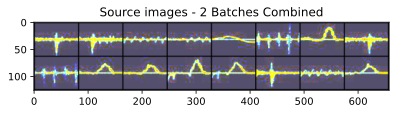

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


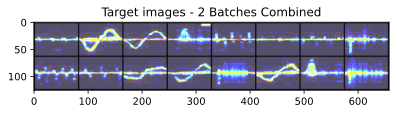

In [22]:
from utils import visualize_batches_from_dataloader

visualize_batches_from_dataloader(source_loader,nbatches=2, cmap='gray', title='Source images')
visualize_batches_from_dataloader(target_train_loader,nbatches=2, cmap='gray', title='Target images')

In [23]:
disc_losses, disc_accuracies, disc_train_counter = [], [], []
clf_disc_losses, clf_disc_train_counter = [], []
clf_losses, clf_accuracies = [], []
clf_test_counter = [idx*iterations*k_clf*target_train_loader.batch_size for idx in range(0, epochs+1)]

In [24]:
test_loss, test_accuracy = 0, 0
clf.eval()
tqdm_bar = tqdm(target_test_loader, desc=f'Testing ', total=int(len(target_test_loader)))

for idx, (images, labels) in enumerate(tqdm_bar):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = clf(images)
        loss = criterion_test(outputs, labels)
    test_loss += loss.item()
    outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)
    test_accuracy += torch.mean((outputs == labels).type(torch.FloatTensor)).item()
    tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_accuracy/(idx+1))
    # _,predicted = torch.max(outputs,axis = 1)
    # test_accuracy += torch.mean((predicted == labels).type(torch.FloatTensor)).item()
    # tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_accuracy/(idx+1))
  
clf_losses.append(test_loss/len(target_test_loader))
clf_accuracies.append(test_accuracy/len(target_test_loader))

Testing : 100%|██████████| 13/13 [00:00<00:00, 66.52it/s, test_accuracy=0.688, test_loss=1.05]


In [25]:
from utils import loop_iterable, load_resnet18_by_featureExtractor_classifier

for epoch in range(epochs):
    target_batch_iterator = loop_iterable(target_train_loader)
    batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_train_loader))
    disc_loss, disc_accuracy = 0, 0
    clf_disc_loss = 0
    test_loss, test_accuracy = 0, 0
    tqdm_bar = tqdm(range(iterations), desc=f'Training Epoch {epoch} ', total=iterations)
    for iter_idx in tqdm_bar:
        # Train discriminator
        set_requires_grad(target_feature_extractor, requires_grad=False)
        set_requires_grad(discriminator, requires_grad=True)
        for disc_idx in range(k_disc):
            (source_x, _), (target_x, _) = next(batch_iterator)
            source_x, target_x = source_x.to(device), target_x.to(device)
            source_features = source_feature_extractor(source_x)
            target_features = target_feature_extractor(target_x)
            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device), torch.zeros(target_x.shape[0], device=device)])
            preds = discriminator(discriminator_x).squeeze()
            loss = criterion_train(preds, discriminator_y)
            discriminator_optim.zero_grad()
            loss.backward()
            discriminator_optim.step()
            disc_loss += loss.item()
            disc_losses.append(loss.item())
            disc_batch_accuracy = ((preds > 0).long() == discriminator_y.long()).float().mean().item()
            disc_accuracy += disc_batch_accuracy
            disc_accuracies.append(disc_batch_accuracy)
            disc_train_counter.append((disc_idx+1)*source_x.size(0) + iter_idx*k_disc*target_train_loader.batch_size + epoch*iterations*k_disc*target_train_loader.batch_size)

        # Train classifier
        set_requires_grad(target_feature_extractor, requires_grad=True)
        set_requires_grad(discriminator, requires_grad=False)
        for clf_idx in range(k_clf):
            _, (target_x, _) = next(batch_iterator)
            target_x = target_x.to(device)
            target_features = target_feature_extractor(target_x).view(target_x.shape[0], -1)
            # Flipped Labels
            discriminator_y = torch.ones(target_x.shape[0], device=device)
            preds = discriminator(target_features).squeeze()
            loss = criterion_train(preds, discriminator_y)
            target_optim.zero_grad()
            loss.backward()
            target_optim.step()
            clf_disc_loss += loss.item()
            clf_disc_losses.append(loss.item())
            clf_disc_train_counter.append(source_x.size(0) + clf_idx*half_batch + iter_idx*k_clf*half_batch + epoch*iterations*k_clf*half_batch)
        tqdm_bar.set_postfix(disc_loss=disc_loss/((iter_idx+1)*k_disc), disc_accuracy=disc_accuracy/((iter_idx+1)*k_disc),
                             clf_disc_loss=clf_disc_loss/((iter_idx+1)*k_clf))

    # Test full target model
    test_loss, test_accuracy = 0, 0
    clf = load_resnet18_by_featureExtractor_classifier(target_feature_extractor,target_classifier)
    clf.eval()
    tqdm_bar = tqdm(target_test_loader, desc=f'Testing Epoch {epoch} (Full Target Model)', total=int(len(target_test_loader)))
    for idx, (images, labels) in enumerate(tqdm_bar):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = clf(images)
            loss = criterion_test(outputs, labels)
        test_loss += loss.item()
        outputs = torch.argmax(outputs, dim=1).type(torch.FloatTensor).to(device)
        test_accuracy += torch.mean((outputs == labels).type(torch.FloatTensor)).item()
        tqdm_bar.set_postfix(test_loss=(test_loss/(idx+1)), test_accuracy=test_accuracy/(idx+1))
    clf_losses.append(test_loss/len(target_test_loader))
    clf_accuracies.append(test_accuracy/len(target_test_loader))
    if np.argmax(clf_accuracies) == len(clf_accuracies)-1:
        print(clf_accuracies[-1])
        torch.save(clf.state_dict(), output_path+'/adda_target_weights.pth')

Testing Epoch 0 (Full Target Model): 100%|██████████| 13/13 [00:00<00:00, 61.39it/s, test_accuracy=0.933, test_loss=0.391]


0.9326923076923077


Testing Epoch 19 (Full Target Model): 100%|██████████| 13/13 [00:00<00:00, 64.73it/s, test_accuracy=0.904, test_loss=0.88]


In [26]:
%config InlineBackend.figure_format = 'svg'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


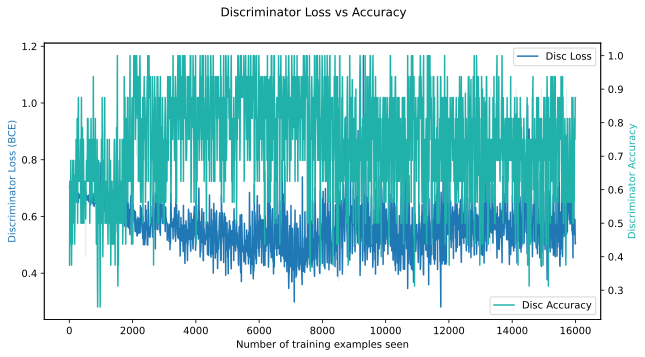

In [34]:
import plotly.graph_objects as go
import plotly.subplots as sp
fig = sp.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=disc_train_counter, y=disc_losses, mode='lines', name='Disc Loss'), secondary_y=False)
fig.add_trace(go.Scatter(x=disc_train_counter, y=disc_accuracies, mode='lines', name='Disc Accuracy', line_color='lightseagreen'), secondary_y=True)
fig.update_layout(
    width=1000,
    height=500,
    title="Discriminator Loss vs Accuracy")
fig.update_xaxes(title_text="Number of training examples seen")
fig.update_yaxes(title_text="Discriminator <b>Loss</b> (BCE)", secondary_y=False)
fig.update_yaxes(title_text="Discriminator <b>Accuracy</b>", secondary_y=True)
fig.show()
fig.write_image(output_path+"/Discriminator_loss_accuracy.pdf")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'Number of training examples seen': disc_train_counter,
    'Disc Loss': disc_losses,
    'Disc Accuracy': disc_accuracies
}

df = pd.DataFrame(data)
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, x='Number of training examples seen', y='Disc Loss', ax=ax1, label='Disc Loss')
ax1.set_xlabel('Number of training examples seen')
ax1.set_ylabel('Discriminator Loss (BCE)', color='tab:blue')
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Number of training examples seen', y='Disc Accuracy', ax=ax2, color='lightseagreen', label='Disc Accuracy')
ax2.set_ylabel('Discriminator Accuracy', color='lightseagreen')
fig.suptitle("Discriminator Loss vs Accuracy")


plt.savefig(output_path+"/Discriminator_loss_accuracy.eps", format='eps', bbox_inches='tight')
plt.savefig(output_path+"/Discriminator_loss_accuracy.png", format='png', bbox_inches='tight',dpi=300)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


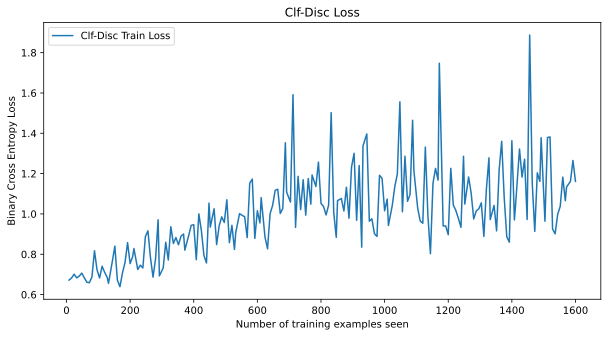

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=clf_disc_train_counter, y=clf_disc_losses, mode='lines', name='Clf-Disc Train Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Clf-Disc Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Binary Cross Entropy Loss"),
fig.show()
fig.write_image(output_path+"/Clf-Disc Loss.pdf")

data = {
    'Number of training examples seen': clf_disc_train_counter,
    'Clf-Disc Train Loss': clf_disc_losses
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Number of training examples seen', y='Clf-Disc Train Loss', label='Clf-Disc Train Loss')
plt.title("Clf-Disc Loss")
plt.xlabel("Number of training examples seen")
plt.ylabel("Binary Cross Entropy Loss")
plt.savefig(output_path+"/Clf-Disc Loss.eps", format='eps', bbox_inches='tight')
plt.savefig(output_path+"/Clf-Disc Loss.png", format='png', bbox_inches='tight',dpi=300)
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


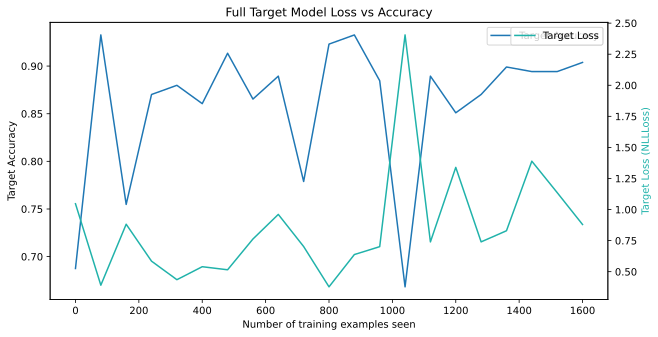

In [36]:
import plotly
fig = plotly.subplots.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=clf_test_counter, y=clf_accuracies, marker_symbol='star-diamond', 
                         marker_line_color="orange", marker_line_width=1, marker_size=9, mode='lines+markers', 
                         name='Target Accuracy'), secondary_y=False)
fig.add_trace(go.Scatter(x=clf_test_counter, y=clf_losses, marker_symbol='star-square', 
                         marker_line_color="lightseagreen", marker_line_width=1, marker_size=9, mode='lines+markers',
                         name='Target Loss'), secondary_y=True)
fig.update_layout(
    width=1000,
    height=500,
    title="Full Target Model Loss vs Accuracy")
fig.update_xaxes(title_text="Number of training examples seen")
fig.update_yaxes(title_text="Target <b>Accuracy</b>", secondary_y=False)
fig.update_yaxes(title_text="Target <b>Loss</b> (NLLLoss)", secondary_y=True)
fig.show()
fig.write_image(output_path+"/Target_Loss_Accuracy Loss.pdf")


import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'Number of training examples seen': clf_test_counter,
    'Target Accuracy': clf_accuracies,
    'Target Loss': clf_losses
}

df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Number of training examples seen', y='Target Accuracy', label='Target Accuracy')
ax2 = plt.twinx()
sns.lineplot(data=df, x='Number of training examples seen', y='Target Loss', ax=ax2, color='lightseagreen', label='Target Loss')
plt.title("Full Target Model Loss vs Accuracy")
plt.xlabel("Number of training examples seen")
plt.ylabel("Target Accuracy")
ax2.set_ylabel("Target Loss (NLLLoss)", color='lightseagreen')
plt.savefig(output_path+"/Target_Loss_Accuracy Loss.eps", format='eps', bbox_inches='tight')
plt.savefig(output_path+"/Target_Loss_Accuracy.png", format='png', bbox_inches='tight',dpi=300)
plt.show()

In [30]:
max(clf_accuracies)

0.9326923076923077

In [37]:
from utils import feature_extractor_resnet18
import torch.nn.functional as nf
import csv

def predict_gesture(model,test_loader,device):
    predicted_list,labels_list = [],[]
    test_loss = 0.0
    test_correct = 0.0
    test_total = 0.0
    all_features = []
    with torch.no_grad():
        model.eval()
        with tqdm(test_loader,desc = 'Test') as t:
            for data in t :
                inputs ,labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                features = feature_extractor_resnet18(model,inputs)
                all_features.append(features.cpu().numpy())
                outputs = model.forward(inputs)
                # outputs2 = model.fc(features)
                # print(torch.equal(outputs,outputs2))
                l = nf.cross_entropy(outputs,labels)
                test_loss += l.item()
                _,predicted = torch.max(outputs,axis = 1)
                predicted_list.append(predicted)
                labels_list.append(labels)
                test_total += labels.size(0)
                test_correct += torch.sum(predicted == labels).item()
                # print(labels,'\n',predicted)
    test_acc = test_correct/test_total
    print("Accuracy: {}".format(test_acc))
    # 打开一个.csv文件进行写入
    with open(output_path + '/test_acc_alone.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        row = [1, test_acc]
        writer.writerow(row)
    predicted_list=[aa.tolist() for aa in predicted_list]
    pred_list_total = [i for item in predicted_list for i in item]
    labels_list=[aa.tolist() for aa in labels_list]
    labels_list_total = [i for item in labels_list for i in item]
    all_features = np.concatenate(all_features, axis=0)
    
    return labels_list_total, pred_list_total, all_features

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Test: 100%|██████████| 13/13 [00:00<00:00, 66.87it/s]


Accuracy: 0.93
Normalized confusion matrix
[[0.98 0.   0.   0.02 0.  ]
 [0.02 0.82 0.12 0.   0.02]
 [0.   0.12 0.88 0.   0.  ]
 [0.   0.02 0.   0.98 0.  ]
 [0.   0.   0.   0.   1.  ]]


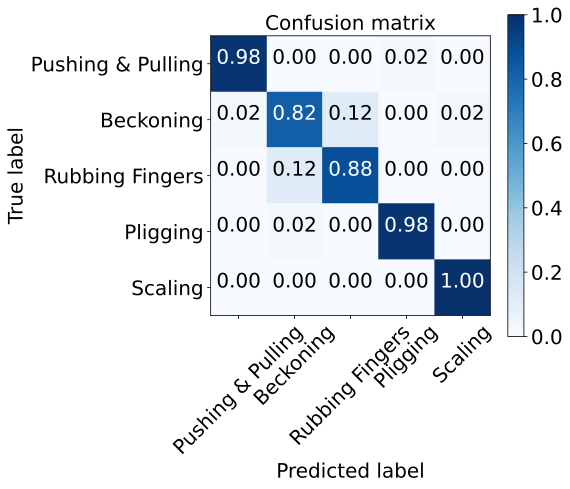

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


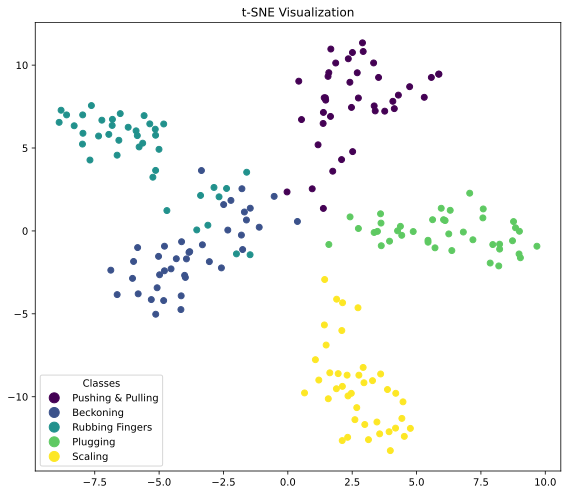

In [32]:
from utils import plot_confusion_matrix, plot_tsne
from models import fc_part
from sklearn.manifold import TSNE


new_model = resnet18(pretrained=True).to(device)
new_model.fc = fc_part().to(device)
new_model.load_state_dict(torch.load(output_path+"/adda_target_weights.pth"))

labels_list_total_test, pred_list_total_test, all_features_test = predict_gesture(new_model,target_test_loader,device)
plot_confusion_matrix(labels=labels_list_total_test,pre=pred_list_total_test,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Pligging','Scaling'],savepath=output_path+'/Test_ConfMatrix',normalize=True)
tsne = TSNE(n_components=2, init='pca',random_state=0)
tsne_result_test = tsne.fit_transform(all_features_test)
plot_tsne(tsne_result_test, labels_list_total_test, classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Plugging','Scaling'], savepath=output_path+'/Test_TSNE')

Test: 100%|██████████| 32/32 [00:00<00:00, 65.14it/s]


Accuracy: 1.0


Test: 100%|██████████| 32/32 [00:00<00:00, 69.22it/s]


Accuracy: 0.932


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


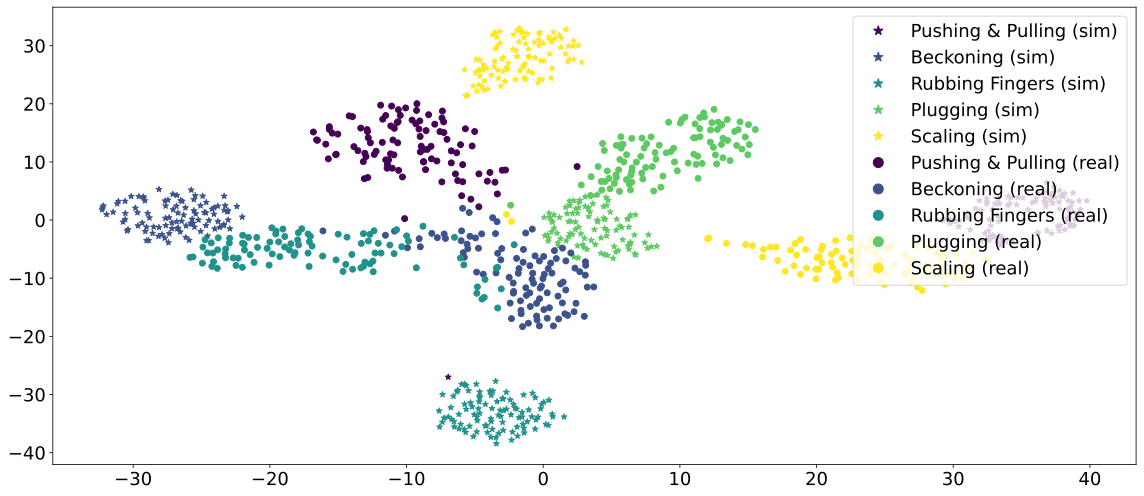

In [38]:
sim_path = './simulated_data/'
real_path = './real_data/'
sim_txt_path = './simulated_data/sim.txt'
real_txt_path= './real_data/real.txt'
sim_all = {}
real_all = {}
for is_sim in [True,False]:
    if is_sim:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            sim_all[category] = glob.glob(os.path.join(sim_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3','pic4','pic5']:
            real_all[category] = glob.glob(os.path.join(real_path + category,'*.jpg'))
mapkey = {
    'pic1' : '0',
    'pic2' : '1',
    'pic3' : '2',
    'pic4' : '3',
    'pic5' : '4',
}
def gen_txt(txt_path, img_paths):
    f = open(txt_path,'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label +'\n'
            f.write(line)
gen_txt(sim_txt_path,sim_all)
gen_txt(real_txt_path,real_all)
sim_data = MyDataset(txt_path=sim_txt_path,transform = sourceTransform)
sim_loader = DataLoader(dataset = sim_data,batch_size = batch_size)
real_data = MyDataset(txt_path=real_txt_path,transform = sourceTransform)
real_loader = DataLoader(dataset = real_data,batch_size = batch_size)

labels_list_total_sim, pred_list_total_sim, all_features_sim = predict_gesture(new_model,sim_loader,device)
labels_list_total_real, pred_list_total_real, all_features_real = predict_gesture(new_model,real_loader,device)

from utils import plot_tsne_v2

RANDOM_STATE_TSNE = 10
tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE_TSNE)
tsne_result_sim = tsne.fit_transform(all_features_sim)
tsne_result_real = tsne.fit_transform(all_features_real)
plot_tsne_v2(tsne_result_sim,labels_list_total_sim,tsne_result_real,labels_list_total_real,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers','Plugging','Scaling'],savepath=output_path+'/ALL_TSNE',legend=True)